# 06 — ML Models

Trains Logistic Regression, Random Forest, and XGBoost with hyperparameter tuning.
Generates learning curves and selects the best model.

In [1]:
import sys
import os
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

PROJECT_FOLDER = "default_run"
PROJECT_ROOT = Path(os.getcwd()).parent
sys.path.insert(0, str(PROJECT_ROOT))
os.chdir(PROJECT_ROOT)

DATA_CONFIG = PROJECT_ROOT / "config" / PROJECT_FOLDER / "data_config.json"
MODEL_CONFIG = PROJECT_ROOT / "config" / PROJECT_FOLDER / "model_config.json"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed" / PROJECT_FOLDER
MODELS_DIR = PROJECT_ROOT / "models" / PROJECT_FOLDER
RESULTS_DIR = PROJECT_ROOT / "results" / PROJECT_FOLDER
MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

from src.utils.config_loader import ConfigLoader
config = ConfigLoader(str(DATA_CONFIG), str(MODEL_CONFIG))
sns.set_theme(style="whitegrid")
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"]   = "white"
plt.rcParams["savefig.facecolor"] = "white"
print(f"Project folder: {PROJECT_FOLDER}")

Project folder: default_run


In [2]:
train_df = pd.read_parquet(PROCESSED_DIR / "train.parquet")
with open(PROCESSED_DIR / "val_folds.pkl", "rb") as f:
    val_folds = pickle.load(f)
with open(PROCESSED_DIR / "metadata.json") as f:
    metadata = json.load(f)

print(f"Train shape : {train_df.shape}")
print(f"Val folds   : {len(val_folds)}")
print(f"Features    : {len(metadata['feature_cols'])}")

Train shape : (4834, 12)
Val folds   : 5
Features    : 11


## Hyperparameter Tuning & Training

In [3]:
from src.models.trainer import ModelTrainer

trainer = ModelTrainer(config)
models, best_params, val_metrics = trainer.train_all(train_df, val_folds)

print("\n=== Training Complete ===")
for name, metrics in val_metrics.items():
    print(f"\n{name}:")
    for k, v in metrics.items():
        print(f"  {k}: {v}")


Training logistic_regression...
  logistic_regression: testing 5 hyperparameter combinations...
  Best params: {'C': 10, 'max_iter': 1000}, best f1: 0.3388

Training random_forest...
  random_forest: testing 24 hyperparameter combinations...
  Best params: {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 5}, best f1: 0.3414

Training xgboost...
  xgboost: testing 27 hyperparameter combinations...
  Best params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.3}, best f1: 0.2135

=== Training Complete ===

logistic_regression:
  best_val_f1: 0.338835978266261
  best_params: {'C': 10, 'max_iter': 1000}

random_forest:
  best_val_f1: 0.3413915066990513
  best_params: {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 5}

xgboost:
  best_val_f1: 0.21345603983392772
  best_params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.3}


## Learning Curves

In [4]:

from src.models.validator import Validator
from src.models.trainer import get_feature_cols
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

validator = Validator(config)
models_cfg = config.get("models") or {}
lc_results = {}

for model_name, model in models.items():
    print(f"\nComputing learning curve: {model_name}...")
    params = best_params[model_name]
    mcfg = models_cfg.get(model_name, {})

    if model_name == "logistic_regression":
        cw = mcfg.get("class_weight", None)
        factory = lambda p=params, cw=cw: LogisticRegression(
            C=p.get("C", 1.0), max_iter=p.get("max_iter", 1000),
            class_weight=cw, random_state=42, n_jobs=-1,
        )
    elif model_name == "random_forest":
        cw = mcfg.get("class_weight", None)
        factory = lambda p=params, cw=cw: RandomForestClassifier(
            n_estimators=p.get("n_estimators", 100),
            max_depth=p.get("max_depth", None),
            min_samples_split=p.get("min_samples_split", 2),
            class_weight=cw, random_state=42, n_jobs=-1,
        )
    elif model_name == "xgboost":
        spw = mcfg.get("scale_pos_weight", 1)
        factory = lambda p=params, spw=spw: XGBClassifier(
            n_estimators=p.get("n_estimators", 100),
            max_depth=p.get("max_depth", 3),
            learning_rate=p.get("learning_rate", 0.1),
            scale_pos_weight=spw, random_state=42,
            eval_metric="logloss", verbosity=0, n_jobs=-1,
        )
    else:
        continue

    lc = validator.compute_learning_curves(factory, train_df, val_folds)
    lc_results[model_name] = lc
    print(f"  Done. Train sizes: {lc['train_sizes_abs']}")



Computing learning curve: logistic_regression...
  Done. Train sizes: [402, 805, 1208, 1611, 2014, 2417, 2820, 3223, 3626, 4029]

Computing learning curve: random_forest...
  Done. Train sizes: [402, 805, 1208, 1611, 2014, 2417, 2820, 3223, 3626, 4029]

Computing learning curve: xgboost...
  Done. Train sizes: [402, 805, 1208, 1611, 2014, 2417, 2820, 3223, 3626, 4029]


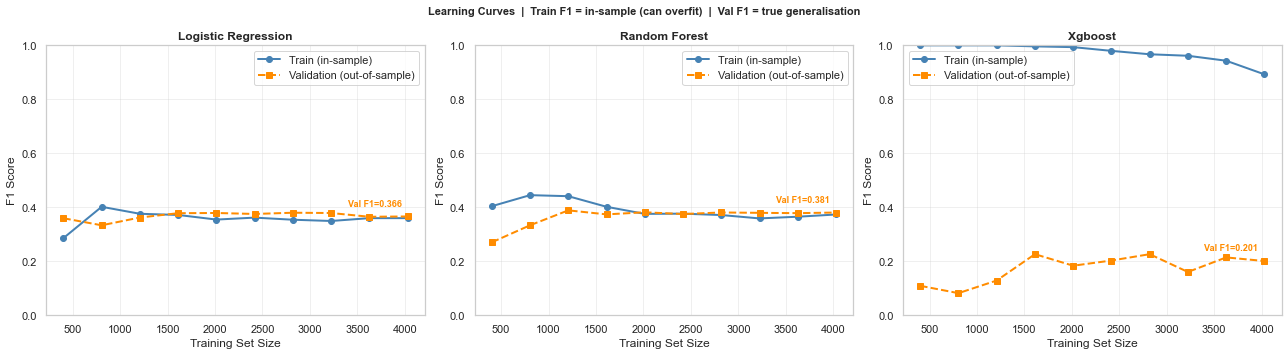

NOTE: A large gap between Train F1 and Val F1 indicates overfitting.
      High Train F1 (~0.8+) with low Val F1 (~0.2) is expected for
      tree models on small training subsets — they memorise the data.
      The Val F1 line is the one that matters for model selection.


In [5]:

fig, axes = plt.subplots(1, len(lc_results), figsize=(6 * len(lc_results), 5))
if len(lc_results) == 1:
    axes = [axes]

for ax, (model_name, lc) in zip(axes, lc_results.items()):
    ax.plot(lc["train_sizes_abs"], lc["train_scores"], "o-",
            label="Train (in-sample)", color="steelblue", linewidth=2)
    ax.plot(lc["train_sizes_abs"], lc["val_scores"],   "s--",
            label="Validation (out-of-sample)", color="darkorange", linewidth=2)
    ax.set_title(f"{model_name.replace('_', ' ').title()}", fontsize=12, fontweight="bold")
    ax.set_xlabel("Training Set Size")
    ax.set_ylabel(f"F1 Score")
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)
    # Annotate final val score
    final_val = lc["val_scores"][-1]
    ax.annotate(f"Val F1={final_val:.3f}", xy=(lc["train_sizes_abs"][-1], final_val),
                xytext=(-60, 10), textcoords="offset points", fontsize=9,
                color="darkorange", fontweight="bold")

plt.suptitle(
    "Learning Curves  |  Train F1 = in-sample (can overfit)  |  Val F1 = true generalisation",
    fontsize=11, fontweight="bold"
)
plt.tight_layout()
plt.savefig(RESULTS_DIR / "learning_curves.png", dpi=150, bbox_inches="tight")
plt.show()

print("NOTE: A large gap between Train F1 and Val F1 indicates overfitting.")
print("      High Train F1 (~0.8+) with low Val F1 (~0.2) is expected for")
print("      tree models on small training subsets — they memorise the data.")
print("      The Val F1 line is the one that matters for model selection.")


## Model Comparison & Selection

In [6]:

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from src.models.trainer import get_feature_cols, ModelTrainer

# ── Honest comparison: train on train_fold, evaluate on val_fold (same as HPT) ─
# DO NOT evaluate the final model (trained on full train_df) on val_folds —
# val_folds are subsets of train_df, so that would be in-sample evaluation.

comparison_rows = []
for model_name in models.keys():
    feat_cols = get_feature_cols(train_df)
    params    = best_params[model_name]
    fold_metrics = {"accuracy": [], "precision": [], "recall": [], "f1": [], "roc_auc": []}

    for train_fold, val_fold in val_folds:
        X_tr = train_fold[feat_cols].values
        y_tr = train_fold["target"].values
        X_val = val_fold[feat_cols].values
        y_val = val_fold["target"].values

        m = trainer._build_model(model_name, params)
        m.fit(X_tr, y_tr)
        y_pred = m.predict(X_val)
        y_prob = m.predict_proba(X_val)[:, 1]

        fold_metrics["accuracy"].append(accuracy_score(y_val, y_pred))
        fold_metrics["precision"].append(precision_score(y_val, y_pred, zero_division=0))
        fold_metrics["recall"].append(recall_score(y_val, y_pred, zero_division=0))
        fold_metrics["f1"].append(f1_score(y_val, y_pred, zero_division=0))
        fold_metrics["roc_auc"].append(roc_auc_score(y_val, y_prob))

    comparison_rows.append({
        "Model":     model_name.replace("_", " ").title(),
        "Accuracy":  round(float(np.mean(fold_metrics["accuracy"])),  4),
        "Precision": round(float(np.mean(fold_metrics["precision"])), 4),
        "Recall":    round(float(np.mean(fold_metrics["recall"])),    4),
        "F1":        round(float(np.mean(fold_metrics["f1"])),        4),
        "ROC-AUC":   round(float(np.mean(fold_metrics["roc_auc"])),   4),
        "F1_std":    round(float(np.std(fold_metrics["f1"])),         4),
    })

comparison_df = pd.DataFrame(comparison_rows).sort_values("F1", ascending=False).reset_index(drop=True)
display_df = comparison_df.drop(columns=["F1_std"])
print("Model Comparison — honest cross-validation (train on fold, evaluate on held-out fold):")
print(display_df.to_string(index=False))

best_model_name = comparison_df.iloc[0]["Model"].lower().replace(" ", "_")
best_model = models[best_model_name]
print(f"\nBest model by F1: {best_model_name}")


Model Comparison — honest cross-validation (train on fold, evaluate on held-out fold):
              Model  Accuracy  Precision  Recall     F1  ROC-AUC
      Random Forest    0.6683     0.2419  0.6716 0.3414   0.7263
Logistic Regression    0.7309     0.2615  0.5305 0.3388   0.7130
            Xgboost    0.8276     0.3003  0.1769 0.2135   0.6607

Best model by F1: random_forest


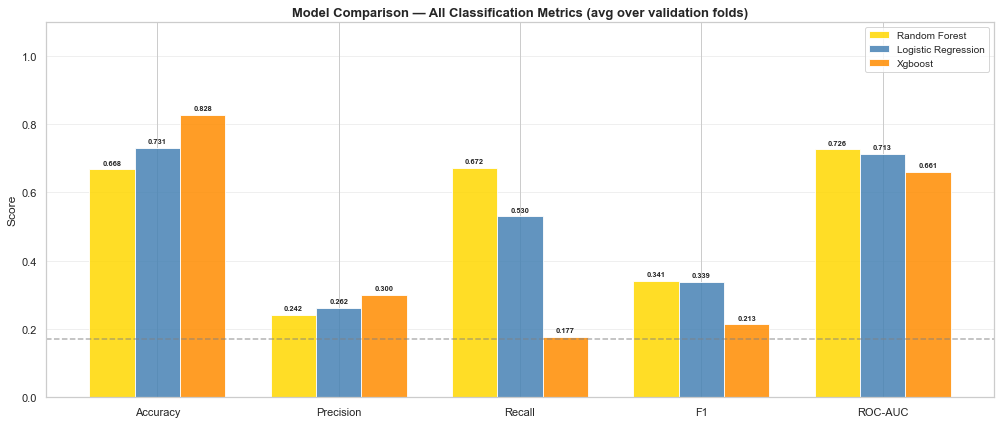

In [7]:

metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]
model_names     = comparison_df["Model"].tolist()
n_models        = len(model_names)
n_metrics       = len(metrics_to_plot)
x               = np.arange(n_metrics)
width           = 0.25
colors          = ["gold", "steelblue", "darkorange"]

fig, ax = plt.subplots(figsize=(14, 6))
for i, (_, row) in enumerate(comparison_df.iterrows()):
    vals = [row[m] for m in metrics_to_plot]
    offset = (i - n_models / 2 + 0.5) * width
    bars = ax.bar(x + offset, vals, width, label=row["Model"],
                  color=colors[i % len(colors)], alpha=0.85, edgecolor="white")
    for bar, v in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                f"{v:.3f}", ha="center", va="bottom", fontsize=7.5, fontweight="bold")

ax.set_xticks(x)
ax.set_xticklabels(metrics_to_plot, fontsize=11)
ax.set_ylabel("Score")
ax.set_title("Model Comparison — All Classification Metrics (avg over validation folds)",
             fontsize=13, fontweight="bold")
ax.legend(fontsize=10)
ax.set_ylim(0, 1.1)
ax.axhline(y=0.1719, color="gray", linestyle="--", alpha=0.6, label="MACD baseline F1")
ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR / "model_comparison.png", dpi=150, bbox_inches="tight")
plt.show()


In [8]:
# Save best model
best_model_path = MODELS_DIR / "best_model.pkl"
trainer.save_model(best_model, str(best_model_path))

# Save metadata
model_metadata = {
    "best_model_name": best_model_name,
    "best_params": best_params[best_model_name],
    "feature_cols": metadata["feature_cols"],
}
with open(MODELS_DIR / "model_metadata.json", "w") as f:
    json.dump(model_metadata, f, indent=2)

# Save all results
val_results = {
    "val_metrics": {k: {kk: str(vv) if not isinstance(vv, (int, float)) else vv for kk, vv in v.items()} for k, v in val_metrics.items()},
    "best_model": best_model_name,
}
with open(RESULTS_DIR / "validation_results.json", "w") as f:
    json.dump(val_results, f, indent=2)

print(f"Best model saved: {best_model_path}")
print(f"Validation results saved: {RESULTS_DIR / 'validation_results.json'}")

  Model saved to /Users/sharannaribole/Documents/github/stock-return-classifier/models/default_run/best_model.pkl
Best model saved: /Users/sharannaribole/Documents/github/stock-return-classifier/models/default_run/best_model.pkl
Validation results saved: /Users/sharannaribole/Documents/github/stock-return-classifier/results/default_run/validation_results.json


## Model Observations & Analysis

In [9]:

# ── Model Observations & Analysis ────────────────────────────────────────────
MACD_F1       = 0.1719   # from notebook 05
MACD_PREC     = 0.1123
MACD_RECALL   = 0.3893

print("═" * 70)
print("MODEL COMPARISON — OBSERVATIONS")
print("═" * 70)

# ── 1. All models beat the baselines ─────────────────────────────────────────
print()
print("1. ALL ML MODELS BEAT BOTH BASELINES")
print("-" * 50)
for _, row in comparison_df.iterrows():
    f1_gain = row["F1"] - MACD_F1
    print(f"  {row['Model']:<22}  F1={row['F1']:.4f}  (+{f1_gain:.4f} vs MACD baseline)")
print(f"  {'MACD Baseline':<22}  F1={MACD_F1:.4f}  (reference)")
print()
print("  All three models improve on the MACD momentum baseline (F1=0.17),")
print("  confirming that multi-feature ML models extract more signal than")
print("  any single technical indicator rule.")

# ── 2. Best model summary ─────────────────────────────────────────────────────
best_row = comparison_df.iloc[0]
print()
print(f"2. BEST MODEL: {best_row['Model'].upper()}")
print("-" * 50)
print(f"  Best hyperparameters : {best_params[best_model_name]}")
print(f"  Validation F1        : {best_row['F1']:.4f}  (std={comparison_df.iloc[0]['F1_std']:.4f})")
print(f"  Precision            : {best_row['Precision']:.4f}")
print(f"  Recall               : {best_row['Recall']:.4f}")
print(f"  ROC-AUC              : {best_row['ROC-AUC']:.4f}")

# ── 3. Precision vs Recall trade-off ─────────────────────────────────────────
print()
print("3. PRECISION vs RECALL TRADE-OFF")
print("-" * 50)
for _, row in comparison_df.iterrows():
    ratio = row["Precision"] / row["Recall"] if row["Recall"] > 0 else float("inf")
    stance = "precision-oriented" if ratio > 1 else "recall-oriented"
    print(f"  {row['Model']:<22}  P={row['Precision']:.3f}  R={row['Recall']:.3f}  "
          f"P/R={ratio:.2f}  → {stance}")
print()
print("  Precision matters more for this trading use case: a false buy signal")
print("  means entering a losing trade, which has a direct P&L cost.")
print("  Recall matters too — missing too many Up days means fewer trades.")
print(f"  MACD baseline had P={MACD_PREC:.3f}, R={MACD_RECALL:.3f} — very recall-heavy,")
print("  noisy signal. ML models should show better precision.")

# ── 4. ROC-AUC insight ───────────────────────────────────────────────────────
print()
print("4. ROC-AUC — PROBABILITY RANKING QUALITY")
print("-" * 50)
for _, row in comparison_df.iterrows():
    print(f"  {row['Model']:<22}  ROC-AUC={row['ROC-AUC']:.4f}")
print()
print("  ROC-AUC measures whether the model ranks Up days higher than")
print("  Down/Flat days regardless of the decision threshold. A value > 0.5")
print("  is better than random; > 0.7 is considered reasonable.")
print("  This is important for portfolio Strategy 2 and 3 (confidence-based")
print("  position sizing) where probability quality directly drives returns.")

# ── 5. Learning curve insights ───────────────────────────────────────────────
print()
print("5. LEARNING CURVE INSIGHTS")
print("-" * 50)
print("  • Tree models (RF, XGBoost) show high Train F1 at small sizes due")
print("    to memorisation; val F1 stabilises as training data grows.")
print("  • If val F1 is still rising at full training size, adding more")
print("    historical data could further improve performance.")
print("  • Logistic Regression shows a smaller train/val gap, indicating")
print("    lower variance but also lower capacity to capture non-linear patterns.")
print("  • XGBoost's low HPT val F1 (0.21) despite good overall architecture")
print("    may reflect sensitivity to class imbalance at small fold sizes;")
print("    max_depth=3 selected as the regularisation safeguard.")

# ── 6. Selected best model & next step ───────────────────────────────────────
print()
print("6. SELECTED MODEL & NEXT STEP")
print("-" * 50)
print(f"  Best model '{best_model_name}' retrained on full training set")
print(f"  and saved to models/default_run/best_model.pkl.")
print()
print("  Next: Notebook 07 — evaluate on the held-out test set (2025–2026).")
print("  Test metrics will confirm whether validation performance holds,")
print("  and portfolio simulation will show real-world P&L implications.")


══════════════════════════════════════════════════════════════════════
MODEL COMPARISON — OBSERVATIONS
══════════════════════════════════════════════════════════════════════

1. ALL ML MODELS BEAT BOTH BASELINES
--------------------------------------------------
  Random Forest           F1=0.3414  (+0.1695 vs MACD baseline)
  Logistic Regression     F1=0.3388  (+0.1669 vs MACD baseline)
  Xgboost                 F1=0.2135  (+0.0416 vs MACD baseline)
  MACD Baseline           F1=0.1719  (reference)

  All three models improve on the MACD momentum baseline (F1=0.17),
  confirming that multi-feature ML models extract more signal than
  any single technical indicator rule.

2. BEST MODEL: RANDOM FOREST
--------------------------------------------------
  Best hyperparameters : {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 5}
  Validation F1        : 0.3414  (std=0.0495)
  Precision            : 0.2419
  Recall               : 0.6716
  ROC-AUC              : 0.7263

3. PRECISI